# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Identify the features of used cars that most impact price so that dealers can refine their inventory to maximize profits.

Identify AI models that best predict the price that consumers are willing to pay for a vehicle so that we can identify the characteristics that customers most look for and are willing to pay for.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Examine the columns in the data set and look for ordinal, nominal, categoric data types.  Consider what kinds of transformations might be beneficial.


Look at the data within individual columns for outliers, data anomolies, and other data issues that prepprocessing could assist us with.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [12]:
vehicles = pd.read_csv('Data/vehicles.csv')

In [13]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

id and VIN fields are not needed and will be dropped.

Nominal fields include: region, manufacturer, model, fuel, title_status, transmission, drive, size, type, paint_color, and state.

Ordinal fields include: condition and cylinders.  These will be converted to numerics.

Quantitative fields include: year, odometer

Price is the target column and the other columns will be considered features.

Let's examine some of the data in the columns:

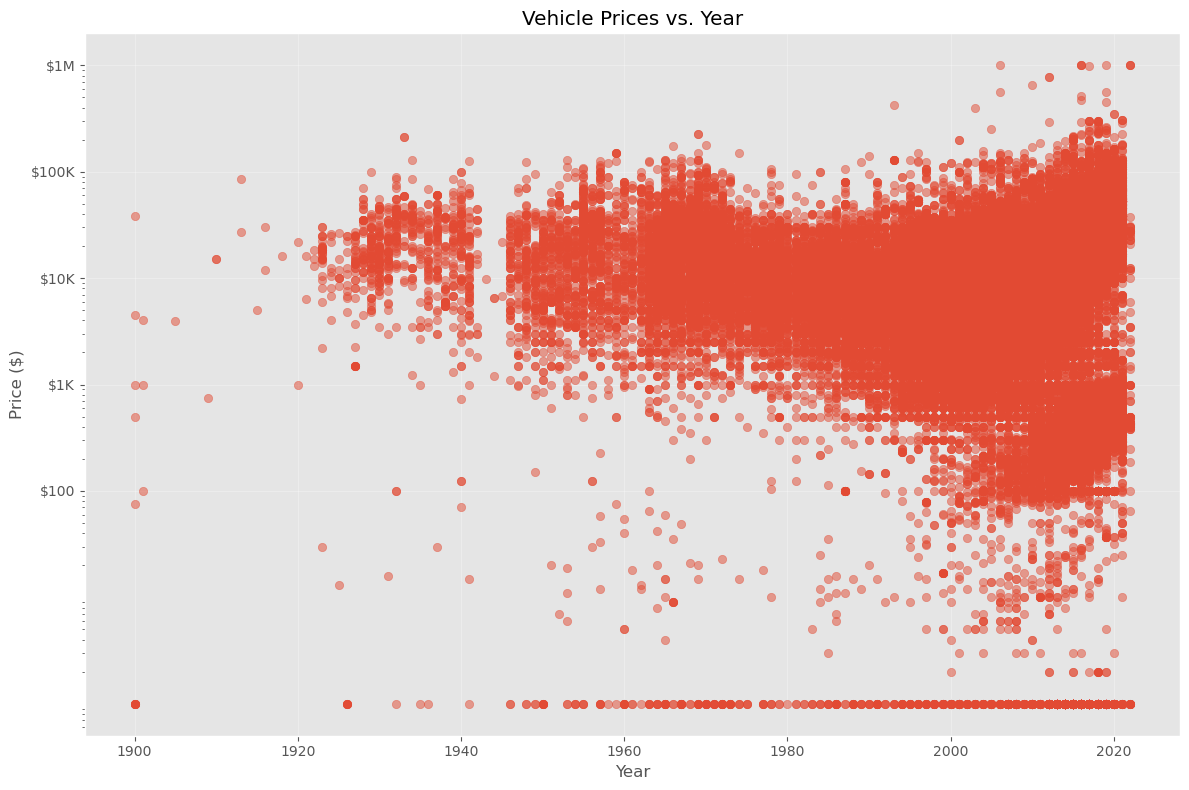


Summary Statistics:
                year           price
count  392759.000000   392759.000000
mean     2011.009062    18875.142726
std         9.623074    16232.813550
min      1900.000000        1.000000
25%      2008.000000     7000.000000
50%      2013.000000    15000.000000
75%      2017.000000    27590.000000
max      2022.000000  1000000.000000

Correlation between Year and Price: 0.31


In [20]:
# Graph Price vs Year to see the prices in a scatter
# Convert price and year to numeric, removing any non-numeric values
vehicles['price'] = pd.to_numeric(vehicles['price'], errors='coerce')
vehicles['year'] = pd.to_numeric(vehicles['year'], errors='coerce')

# Remove rows with missing price or year, and filter out extreme prices
vehicles = vehicles[(vehicles['price'] > 0) & (vehicles['price'] <= 1000000) & (vehicles['year'].notna())]

# Set the style
plt.style.use('ggplot')

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(vehicles['year'], vehicles['price'], alpha=0.5)

plt.title('Vehicle Prices vs. Year')
plt.xlabel('Year')
plt.ylabel('Price ($)')

# Use log scale for y-axis due to wide range of prices
plt.yscale('log')

# Customize y-axis ticks for better readability
plt.yticks([100, 1000, 10000, 100000, 1000000], 
           ['$100', '$1K', '$10K', '$100K', '$1M'])

# Add grid lines
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# Display summary statistics
print("\nSummary Statistics:")
print(vehicles[['year', 'price']].describe())

# Calculate and display correlation between year and price
correlation = vehicles['year'].corr(vehicles['price'])
print(f"\nCorrelation between Year and Price: {correlation:.2f}")

While there are some low value prices, I have decided I don't want to remove them.  If there are factors that make a car not worth much, we want to capture that. Assuming that it is bad data may remove useful indicators of low value.

Looking at the data file, "region" is too varied to be useful at this stage and will be dropped.

"year" is null in very few cases. These rows can be dropped.

Manufacturer and Model may be useful later.

Let's look at the condition codes so we can encode this ordinal field.

In [26]:
# Examine "condition"
# Display unique condition values
print("Unique condition values:")
print(vehicles['condition'].unique())

# Display value counts
print("\nCount of each condition:")
print(vehicles['condition'].value_counts())

Unique condition values:
['good' 'excellent' 'fair' nan 'like new' 'new' 'salvage']

Count of each condition:
condition
good         119142
excellent     94924
like new      20055
fair           6723
new            1132
salvage         595
Name: count, dtype: int64


I'll encode this field to order (salvage, fair, good, excellent, like new, new)

In [28]:
# Examine "cyclinders"
# Display unique cylinder values
print("Unique cylinders values:")
print(vehicles['cylinders'].unique())

# Display value counts
print("\nCount of each cyclinders:")
print(vehicles['cylinders'].value_counts())

Unique cylinders values:
['8 cylinders' '6 cylinders' nan '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']

Count of each cyclinders:
cylinders
6 cylinders     88385
4 cylinders     72655
8 cylinders     66463
5 cylinders      1670
10 cylinders     1382
other            1083
3 cylinders       606
12 cylinders      204
Name: count, dtype: int64


With lots of null values, we will need a plan to handle the null values and "other".  The values naming cylinders can be considered ordinal and converted to the actual number of cyclinders for a useful numeric field. 

In [30]:
# Examine "fuel"
# Display unique condition values
print("Unique fuel values:")
print(vehicles['fuel'].unique())

# Display value counts
print("\nCount of each fuel:")
print(vehicles['fuel'].value_counts())

Unique fuel values:
['gas' 'other' 'diesel' 'hybrid' nan 'electric']

Count of each fuel:
fuel
gas         329638
other        28098
diesel       26184
hybrid        4881
electric      1623
Name: count, dtype: int64


Few null values.  Drop the nulls and the one-hot-encode the fuel values.

Examine odometer

'odometer' is a numeric with few nulls.  I will drop those.

In [34]:
# Examine "title_status"
# Display unique title_status values
print("Unique title_status values:")
print(vehicles['title_status'].unique())

# Display value counts
print("\nCount of each title_status:")
print(vehicles['title_status'].value_counts())

Unique title_status values:
['clean' 'rebuilt' 'lien' nan 'salvage' 'missing' 'parts only']

Count of each title_status:
title_status
clean         372068
rebuilt         7029
salvage         3837
lien            1421
missing          786
parts only       188
Name: count, dtype: int64


null, lien, missing, salvage and parts only rows can be dropped.  Then the column will be dropped.  

In [36]:
# Examine "transmition"
# Display unique transmission values
print("Unique transmission values:")
print(vehicles['transmission'].unique())

# Display value counts
print("\nCount of each transmission:")
print(vehicles['transmission'].value_counts())

Unique transmission values:
['other' 'automatic' 'manual' nan]

Count of each transmission:
transmission
automatic    305713
other         61457
manual        23828
Name: count, dtype: int64


I'll one hot encode (automatic and manual). Others and nulls can be ignored.

In [38]:
# Examine "drive"
# Display unique drive values
print("Unique drive values:")
print(vehicles['drive'].unique())

# Display value counts
print("\nCount of each drive:")
print(vehicles['drive'].value_counts())

Unique drive values:
[nan 'rwd' '4wd' 'fwd']

Count of each drive:
drive
4wd    120277
fwd     97296
rwd     55244
Name: count, dtype: int64


Same situation as transmission.  I'll one-hot encode the 3 values and ignore nulls.

In [40]:
# Examine "size"
# Display unique size values
print("Unique size values:")
print(vehicles['size'].unique())

# Display value counts
print("\nCount of each size:")
print(vehicles['size'].value_counts())

Unique size values:
[nan 'full-size' 'mid-size' 'compact' 'sub-compact']

Count of each size:
size
full-size      58495
mid-size       31921
compact        17732
sub-compact     2885
Name: count, dtype: int64


"size" is tricky.  It looks like an ordinal with increasing size categories.  However, in the context of car pricing, bigger or smaller does not correlate to price.  Given the large number of null values, this column lends itself to one-hot encoding.  While I don't expect much value from that, I'll include it and then look at number of sales by 'size' later.

In [42]:
# Examine "type"
# Display unique type values
print("Unique type values:")
print(vehicles['type'].unique())

# Display value counts
print("\nCount of each type:")
print(vehicles['type'].value_counts())

Unique type values:
['pickup' 'truck' 'other' nan 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'convertible' 'wagon' 'van']

Count of each type:
type
sedan          80124
SUV            70299
pickup         40992
truck          30627
other          19873
coupe          18190
hatchback      15907
wagon          10064
van             7883
convertible     7430
mini-van        4552
offroad          593
bus              499
Name: count, dtype: int64


Looks like another one-hot.  Similar to 'size', I will look at number of sales by type separately.

In [44]:
# Examine "paint_color"
# Display unique paint_color values
print("Unique paint_color values:")
print(vehicles['paint_color'].unique())

# Display value counts
print("\nCount of each paint_color:")
print(vehicles['paint_color'].value_counts())

Unique paint_color values:
['white' 'blue' 'red' 'black' 'silver' 'grey' nan 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']

Count of each paint_color:
paint_color
white     72504
black     58301
silver    39940
blue      29395
red       28731
grey      22688
green      7075
custom     6410
brown      6175
yellow     2033
orange     1852
purple      677
Name: count, dtype: int64


paint_color is a field that I feel I should treat differently.  While it is clear that color will impact price, this is a feature that should be considered later in the process as it combines with other features.  Think of a red sports car vs a white minivan.  We should be able to think of ways to evaluate this later.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Drop all null prices, year or odometer.

In [48]:
# Drop rows with null prices, years, or odometer readings
vehicles = vehicles.dropna(subset=['price', 'year', 'odometer'])

Drop region, VIN

In [50]:
# Drop 'id','region' and 'VIN' columns
vehicles = vehicles.drop(['id','region', 'VIN'], axis=1)

Encode "condition, I'll encode this field to include the ordinal order (salvage, fair, good, excellent, like new, new)

Convert cylinders to a numeric field.  We'll likely remove nulls to process the numeric later and perform some analysis with just cylinders to understand it's impact. 

In [53]:
# Convert cylinders to numeric
def clean_cylinders(value):
    if pd.isna(value) or value == 'other':
        return np.nan
    return pd.to_numeric(str(value).lower().replace('cylinders', '').strip(), errors='coerce')

vehicles['cylinders'] = vehicles['cylinders'].apply(clean_cylinders)

fuel: Few null values. Drop the nulls and the one-hot-encode the fuel values.

title_status drop (null, lien, missing, salvage, and parts only)

In [56]:
# Delete rows where title_status is null, lien, salvage or 'parts only'
vehicles = vehicles[~vehicles['title_status'].isin([np.nan, 'lien', 'salvage', 'parts only'])]

In [57]:
# Drop 'title_status' columns
vehicles = vehicles.drop(['title_status'], axis=1)

I'll one hot encode transmission (automatic and manual). Others and nulls can be ignored.

In [59]:
# One-hot encode the categorical columns:'fuel', 'transmission', 'drive', 'size', 'type'
columns_to_encode = ['fuel', 'transmission', 'drive', 'size', 'type']
encoded_dfs = []

for col in columns_to_encode:
    encoded_df = pd.get_dummies(vehicles[col], prefix=col, dummy_na=True)
    encoded_dfs.append(encoded_df)

# Drop the original categorical columns and concatenate the one-hot encoded columns
vehicles = pd.concat([vehicles.drop(columns_to_encode, axis=1)] + encoded_dfs, axis=1)


In [60]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377867 entries, 27 to 426879
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   price                   377867 non-null  int64  
 1   year                    377867 non-null  float64
 2   manufacturer            363339 non-null  object 
 3   model                   373400 non-null  object 
 4   condition               231751 non-null  object 
 5   cylinders               220196 non-null  float64
 6   odometer                377867 non-null  float64
 7   paint_color             269704 non-null  object 
 8   state                   377867 non-null  object 
 9   fuel_diesel             377867 non-null  bool   
 10  fuel_electric           377867 non-null  bool   
 11  fuel_gas                377867 non-null  bool   
 12  fuel_hybrid             377867 non-null  bool   
 13  fuel_other              377867 non-null  bool   
 14  fuel_nan                

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Correlations with price:
price                     1.000000
cylinders                 0.330751
year                      0.311343
transmission_other        0.251529
fuel_diesel               0.246367
type_pickup               0.202805
drive_4wd                 0.187240
size_nan                  0.176366
fuel_other                0.158287
type_truck                0.151014
type_other                0.127965
type_coupe                0.056144
drive_rwd                 0.051228
fuel_electric             0.026037
type_convertible          0.015695
transmission_nan          0.011911
fuel_nan                  0.008509
type_offroad             -0.006546
type_bus                 -0.009919
drive_nan                -0.010120
type_van                 -0.010169
fuel_hybrid              -0.023792
size_sub-compact         -0.032501
type_SUV                 -0.038610
type_wagon               -0.047266
type_hatchback           -0.049048
transmission_manual      -0.062014
type_mini-van            -0.06

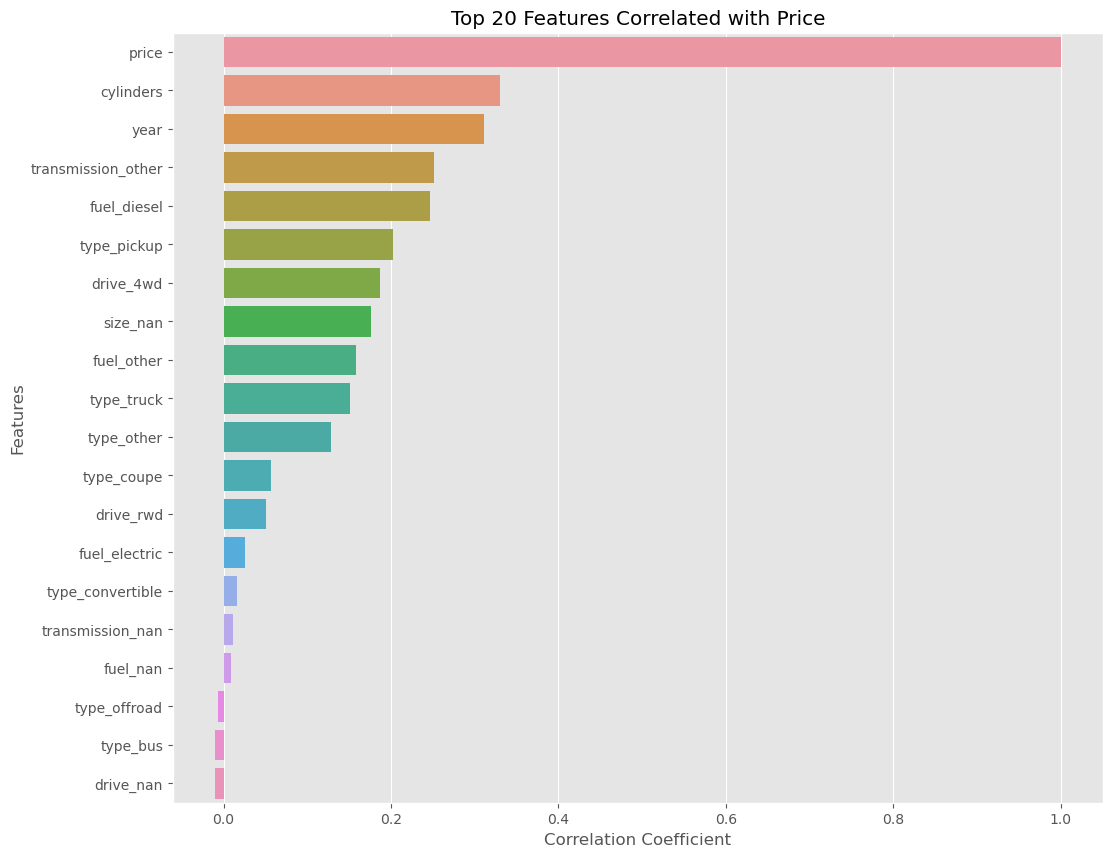

In [62]:
# Separate numeric columns (including one-hot encoded) from non-numeric
# Select numeric and boolean columns
X = vehicles.select_dtypes(include=['number', 'bool'])

# Calculate correlation with price
correlations = X.corr()['price'].sort_values(ascending=False)

# Display correlations
print("Correlations with price:")
print(correlations)

# Visualize top 20 correlations
plt.figure(figsize=(12, 10))
sns.barplot(x=correlations.head(20).values, y=correlations.head(20).index)
plt.title('Top 20 Features Correlated with Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

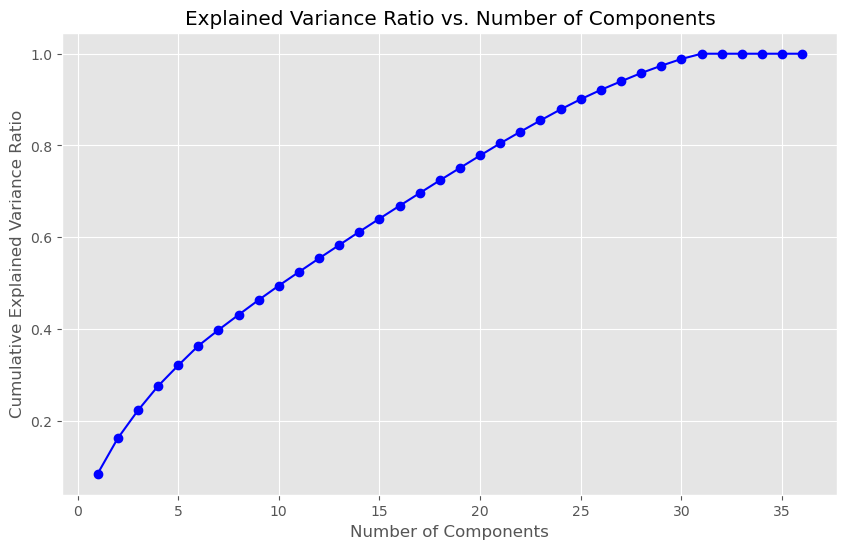

Number of components needed to explain 95% of the variance: 28

Explained variance ratio for the first 10 components:
PC1: 0.0840
PC2: 0.0772
PC3: 0.0607
PC4: 0.0532
PC5: 0.0450
PC6: 0.0428
PC7: 0.0346
PC8: 0.0330
PC9: 0.0325
PC10: 0.0312

Top 10 features contributing to Principal Component 1:
drive_fwd: 0.4013
cylinders: 0.3674
type_sedan: 0.2879
transmission_other: 0.2737
type_pickup: 0.2699
fuel_gas: 0.2491
transmission_automatic: 0.2359
size_mid-size: 0.2331
size_nan: 0.2269
fuel_diesel: 0.2148

Top 10 features contributing to Principal Component 2:
size_full-size: 0.3823
transmission_automatic: 0.3654
transmission_other: 0.3562
size_nan: 0.3364
type_truck: 0.3001
drive_nan: 0.2594
drive_4wd: 0.2571
fuel_diesel: 0.2449
cylinders: 0.1885
type_other: 0.1852

Top 10 features contributing to Principal Component 3:
drive_rwd: 0.4802
year: 0.3994
transmission_manual: 0.3478
type_coupe: 0.3026
drive_4wd: 0.2753
type_convertible: 0.2368
type_SUV: 0.2352
transmission_automatic: 0.2220
size_

In [63]:
# Drop rows with null cylinders
vehicles_cylinders = vehicles.copy().dropna(subset=['cylinders'])

# Separate numeric columns (including one-hot encoded) from non-numeric
numeric_columns = vehicles_cylinders.select_dtypes(include=[np.number]).columns
X = vehicles_cylinders.select_dtypes(include=['number', 'bool']).drop('price', axis=1)  # Remove price from features
y = vehicles_cylinders['price']  # Price is our target

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Print the number of components needed to explain 95% of the variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed to explain 95% of the variance: {n_components_95}")

# Print the explained variance ratio for the first few components
print("\nExplained variance ratio for the first 10 components:")
for i, ratio in enumerate(pca.explained_variance_ratio_[:10], 1):
    print(f"PC{i}: {ratio:.4f}")

# Function to get top features for a component
def get_top_features(component, feature_names, n=10):
    abs_component = np.abs(component)
    component_pairs = sorted(zip(abs_component, feature_names), key=lambda x: x[0], reverse=True)
    return [(feature, weight) for weight, feature in component_pairs[:n]]

# Get and print top features for the first 4 components
for i in range(3):
    print(f"\nTop 10 features contributing to Principal Component {i+1}:")
    top_features = get_top_features(pca.components_[i], X.columns)
    for feature, weight in top_features:
        print(f"{feature}: {weight:.4f}")

# Calculate correlation between principal components and price
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['price'] = y
correlations = pca_df.corr()['price'].sort_values(ascending=False)

print("\nCorrelations between principal components and price:")
print(correlations.head(10))  # Show top 10 correlations


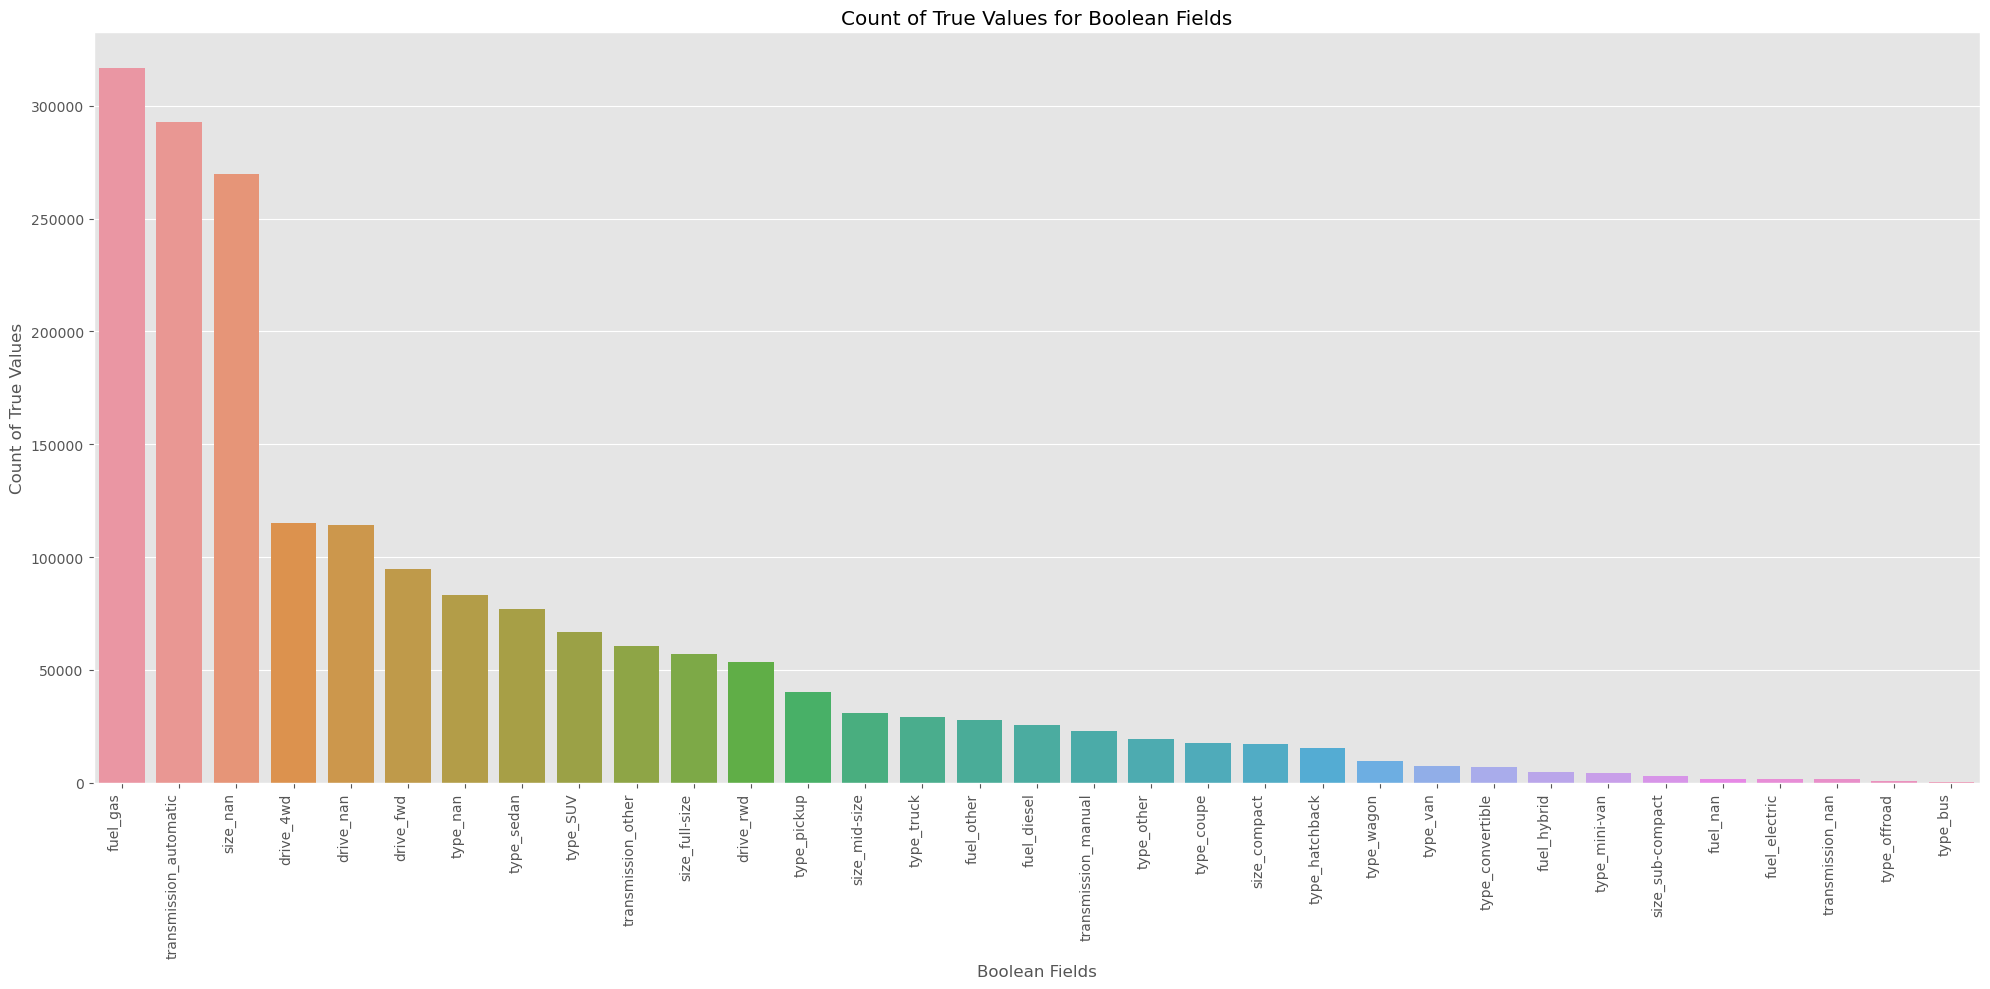

                         Count  Percentage
fuel_gas                316761       83.83
transmission_automatic  292813       77.49
size_nan                269931       71.44
drive_4wd               115019       30.44
drive_nan               114322       30.25
drive_fwd                94850       25.10
type_nan                 83120       22.00
type_sedan               76871       20.34
type_SUV                 66585       17.62
transmission_other       60658       16.05
size_full-size           56913       15.06
drive_rwd                53676       14.20
type_pickup              40103       10.61
size_mid-size            31096        8.23
type_truck               29123        7.71
fuel_other               27822        7.36
fuel_diesel              25424        6.73
transmission_manual      22927        6.07
type_other               19398        5.13
type_coupe               17512        4.63
size_compact             17163        4.54
type_hatchback           15464        4.09
type_wagon 

In [64]:
# Select boolean columns
bool_columns = vehicles.select_dtypes(include=['bool']).columns

# Calculate the count of True values for each boolean column
bool_counts = vehicles[bool_columns].sum().sort_values(ascending=False)

# Calculate total number of rows
total_rows = len(vehicles)

# Calculate percentage of True values
bool_percentages = (bool_counts / total_rows * 100).round(2)

# Create a DataFrame with counts and percentages
bool_df = pd.DataFrame({
    'Count': bool_counts,
    'Percentage': bool_percentages
})

# Sort the DataFrame by Count in descending order
bool_df = bool_df.sort_values('Count', ascending=False)

# Create the plot
plt.figure(figsize=(20, 10))
sns.barplot(x=bool_df.index, y='Count', data=bool_df)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

plt.title('Count of True Values for Boolean Fields')
plt.xlabel('Boolean Fields')
plt.ylabel('Count of True Values')
plt.tight_layout()
plt.show()

# Print the DataFrame for a tabular view
print(bool_df)

Loading and cleaning data...

Engineering features...

Analyzing price relationships...


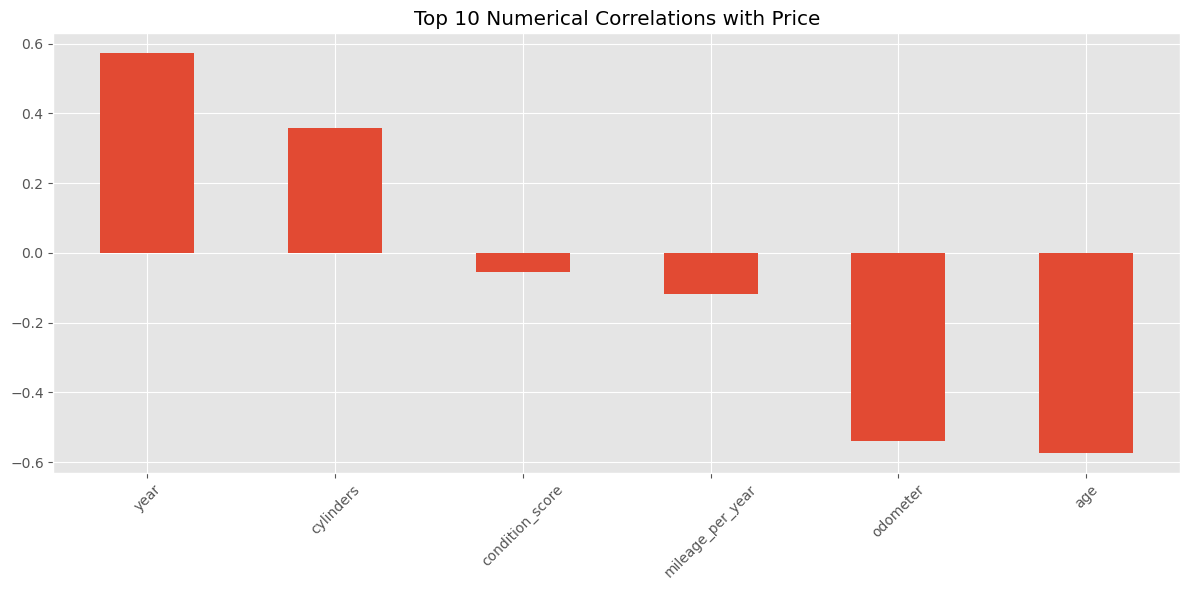

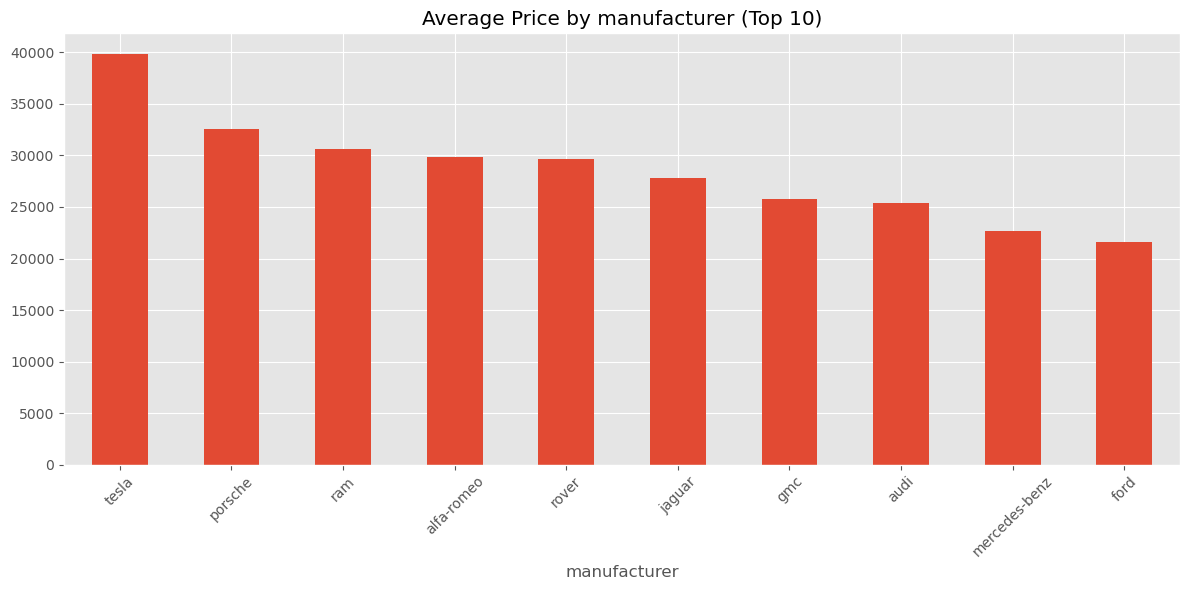

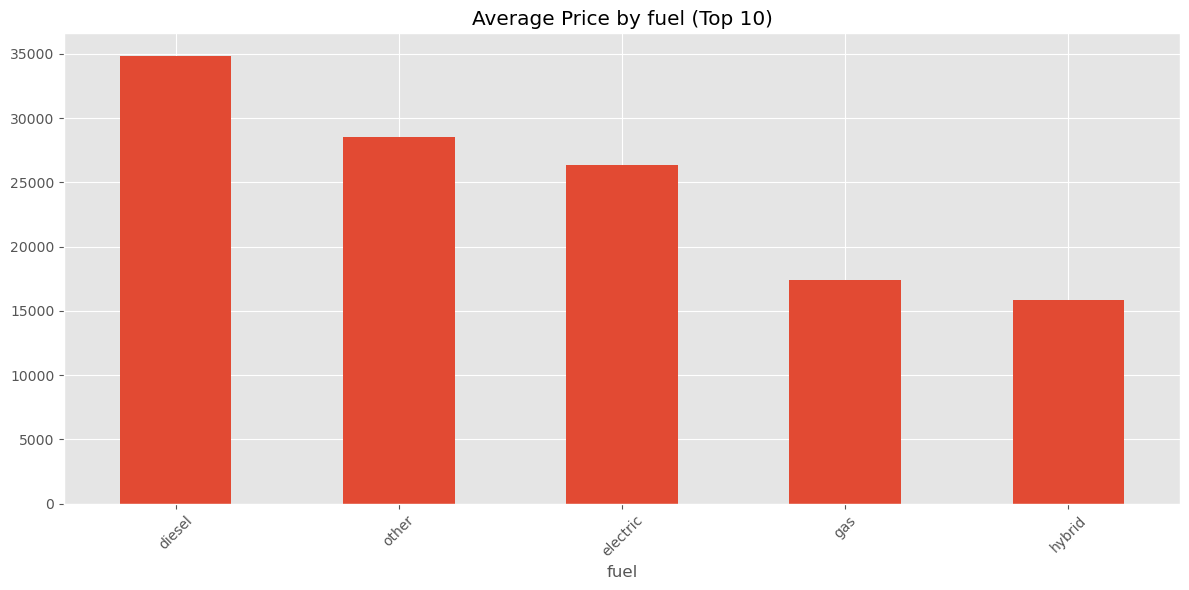

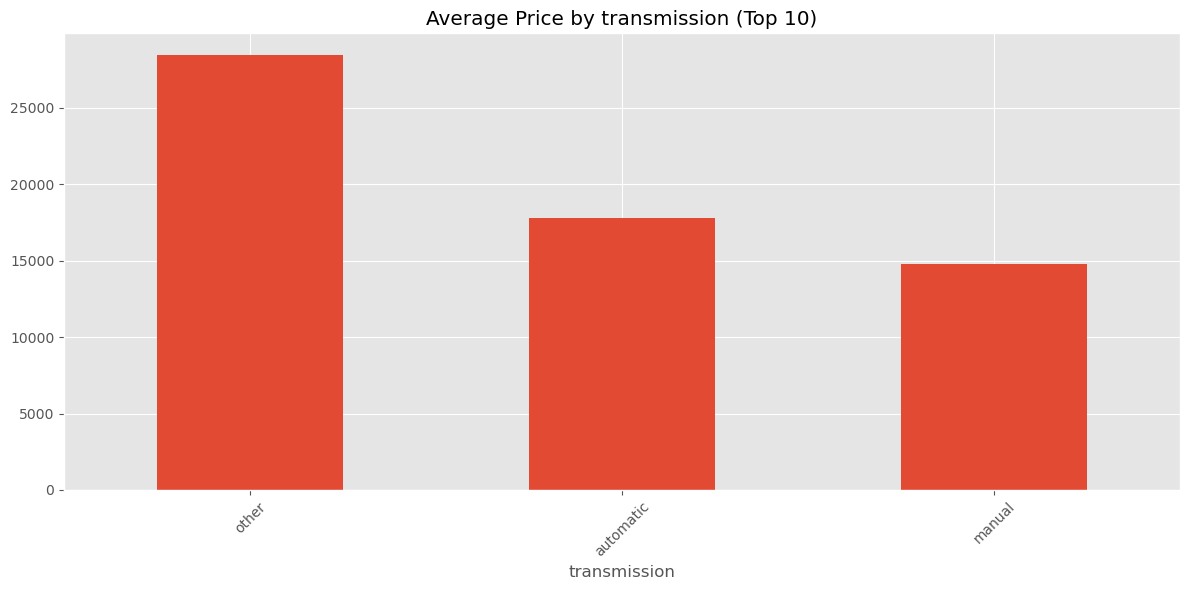

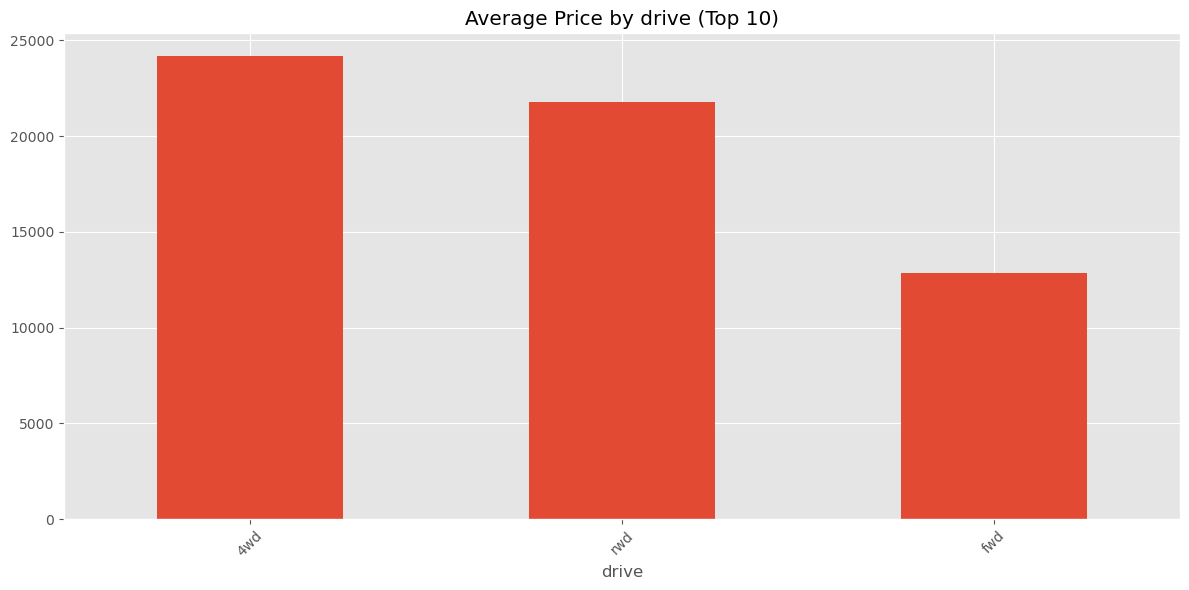

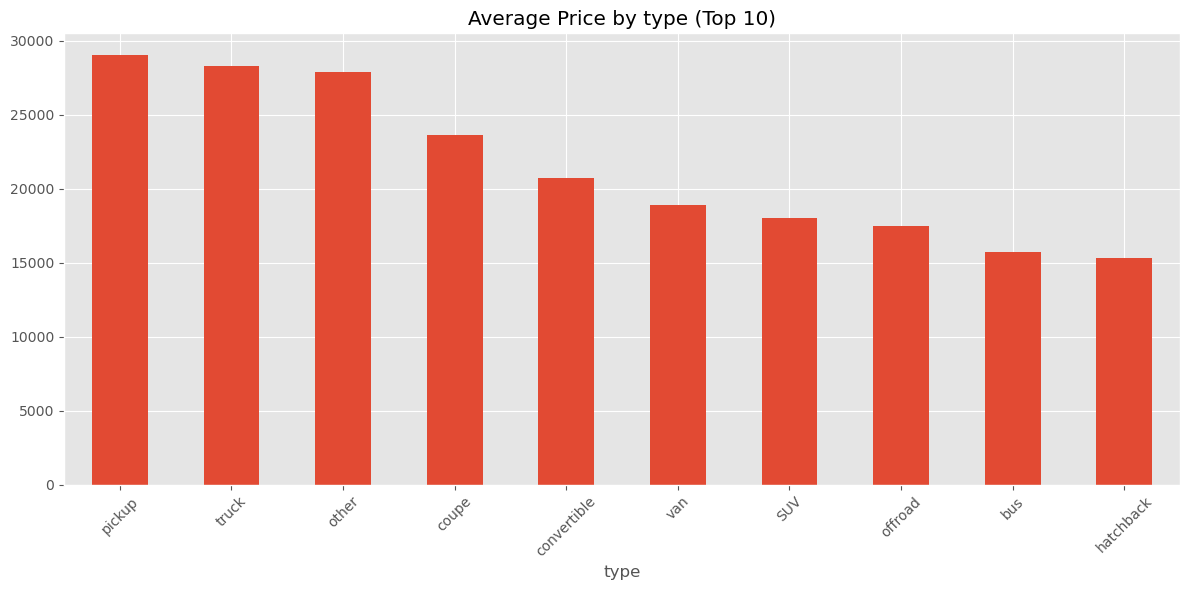


Analyzing feature importance...


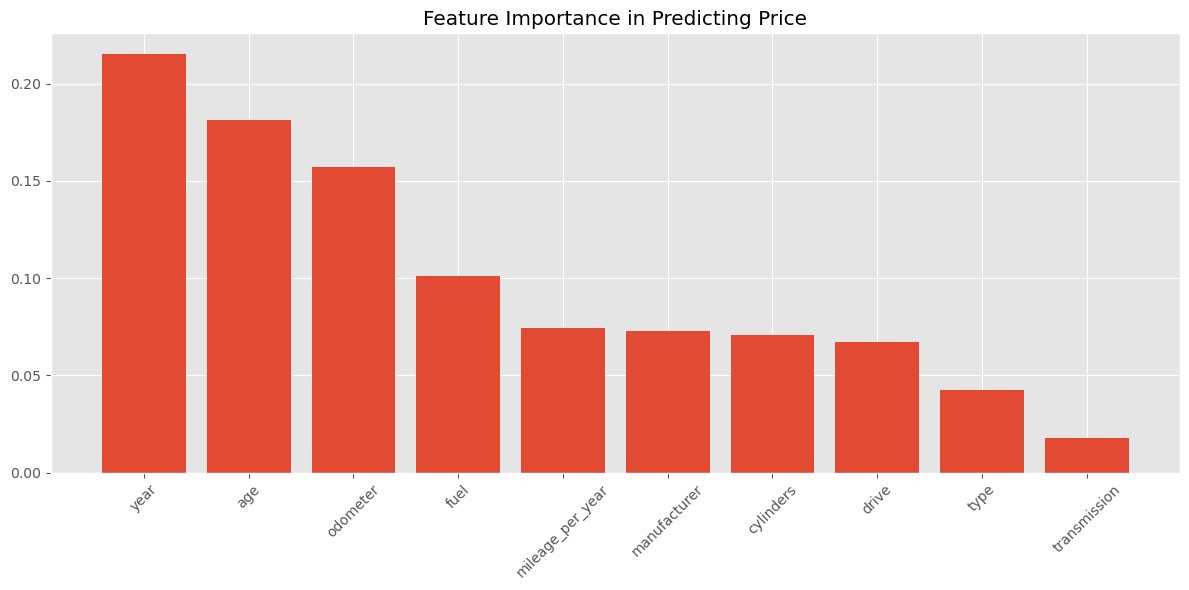

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean the data
def load_and_clean_data(filepath):
    # Read the data
    df = pd.read_csv(filepath)
    
    # Remove irrelevant columns
    df = df.drop(['id', 'region', 'VIN'], axis=1)
    
    # Handle price outliers
    df = df[(df['price'] > 500) & (df['price'] <= 150000)]  # More realistic price range
    
    # Clean year data
    current_year = 2022
    df = df[(df['year'] >= 1990) & (df['year'] <= current_year)]  # Modern era vehicles
    
    # Clean odometer readings
    df = df[(df['odometer'] >= 0) & (df['odometer'] <= 300000)]  # Realistic mileage
    
    return df

# Feature engineering
def engineer_features(df):
    # Create age feature (avoid division by zero)
    current_year = 2022
    df['age'] = current_year - df['year']
    df['age'] = df['age'].clip(lower=0.1)  # Minimum age of 0.1 years to avoid division by zero
    
    # Create mileage_per_year (with handling for edge cases)
    df['mileage_per_year'] = df['odometer'] / df['age']
    df['mileage_per_year'] = df['mileage_per_year'].clip(upper=100000)  # Cap at reasonable maximum
    
    # Encode condition
    condition_map = {
        'salvage': 0, 'fair': 1, 'good': 2, 
        'excellent': 3, 'like new': 4, 'new': 5
    }
    df['condition_score'] = df['condition'].map(condition_map)
    
    # Clean cylinders
    df['cylinders'] = df['cylinders'].replace('other', np.nan)
    df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype(float)
    
    # Create price segments
    df['price_segment'] = pd.qcut(df['price'], q=5, labels=['budget', 'economy', 'mid-range', 'luxury', 'premium'])
    
    return df

# Analyze price relationships
def analyze_price_relationships(df):
    # Numerical correlations
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlations = df[numeric_cols].corr()['price'].sort_values(ascending=False)
    
    # Plot correlations
    plt.figure(figsize=(12, 6))
    correlations[1:11].plot(kind='bar')  # Exclude price self-correlation
    plt.title('Top 10 Numerical Correlations with Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Categorical analysis
    categorical_cols = ['manufacturer', 'fuel', 'transmission', 'drive', 'type']
    for col in categorical_cols:
        if col in df.columns:
            avg_price = df.groupby(col)['price'].agg(['mean', 'count'])
            avg_price = avg_price[avg_price['count'] > 100]  # Filter for significance
            avg_price = avg_price.sort_values('mean', ascending=False)
            
            plt.figure(figsize=(12, 6))
            avg_price['mean'].head(10).plot(kind='bar')
            plt.title(f'Average Price by {col} (Top 10)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Feature importance analysis using Random Forest
def analyze_feature_importance(df):
    # Prepare data for modeling
    cat_cols = ['manufacturer', 'fuel', 'transmission', 'drive', 'type']
    num_cols = ['year', 'odometer', 'cylinders', 'age', 'mileage_per_year']
    
    # Encode categorical variables
    df_encoded = df.copy()
    le = LabelEncoder()
    for col in cat_cols:
        if col in df.columns:
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    
    # Select features and handle missing values
    features = [col for col in cat_cols + num_cols if col in df_encoded.columns]
    X = df_encoded[features].fillna(-1)
    
    # Replace infinite values with large finite values
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())
    
    y = df_encoded['price']
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    
    # Plot feature importance
    importance = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(importance['feature'], importance['importance'])
    plt.title('Feature Importance in Predicting Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return importance

# Main analysis function
def analyze_car_prices(filepath):
    try:
        # Load and clean data
        print("Loading and cleaning data...")
        df = load_and_clean_data(filepath)
        
        # Engineer features
        print("\nEngineering features...")
        df = engineer_features(df)
        
        # Analyze price relationships
        print("\nAnalyzing price relationships...")
        analyze_price_relationships(df)
        
        # Analyze feature importance
        print("\nAnalyzing feature importance...")
        importance = analyze_feature_importance(df)
        
        return df, importance
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

# Run the analysis
df, importance = analyze_car_prices('Data/vehicles.csv')

Preparing data...

Price Distribution:
count    366247.000000
mean      19400.396336
std       14688.882441
min         501.000000
25%        7950.000000
50%       15990.000000
75%       27990.000000
max      150000.000000
Name: price, dtype: float64

Dataset size after cleaning: 366247 samples

Features included:
['year', 'odometer', 'cylinders', 'manufacturer', 'fuel', 'transmission', 'drive', 'type']

Training and comparing models...

Training Random Forest...

Training XGBoost...

Model Performance Comparison:

Random Forest Results:
Training RMSE: $2,011.82
Testing RMSE: $5,130.47
Training R²: 0.981
Testing R²: 0.877
Training MAPE: 13.7%
Testing MAPE: 36.6%
Cross-validation R² (mean ± std): 0.802 ± 0.028

Top 5 Most Important Features:
year            0.417236
odometer        0.194773
fuel            0.100855
cylinders       0.092552
manufacturer    0.077746

XGBoost Results:
Training RMSE: $6,819.28
Testing RMSE: $6,814.70
Training R²: 0.785
Testing R²: 0.783
Training MAPE: 59.3%

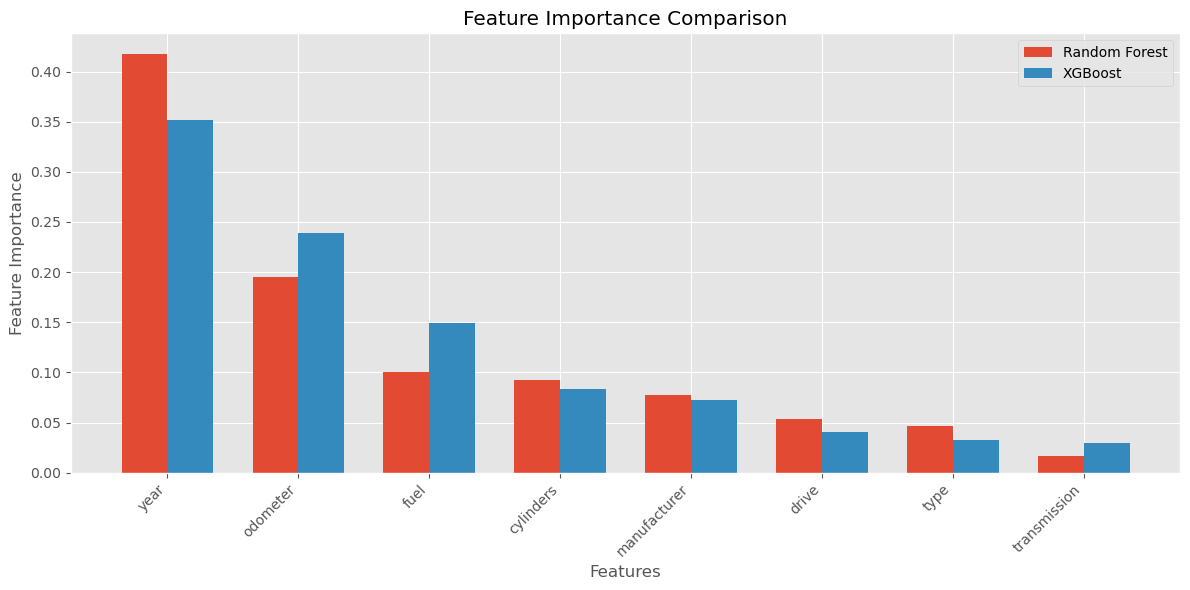

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

def prepare_data_for_modeling(df):
    """Prepare data for modeling with proper preprocessing"""
    # Clean and filter data
    df_clean = df.copy()
    
    # Remove only unreasonably low values
    df_clean = df_clean[
        (df_clean['price'] > 500) &  # Remove extremely low prices
        (df_clean['year'] >= 1900)    # Remove unreasonably old years
    ]
    
    # Select features
    features = ['year', 'odometer', 'cylinders', 'manufacturer', 'fuel', 
                'transmission', 'drive', 'type']
    
    # Keep only rows where we have the target variable
    df_clean = df_clean.dropna(subset=['price'])
    
    # Create feature matrix and target vector
    X = df_clean[features].copy()
    y = df_clean['price']
    
    # Print price distribution statistics
    print("\nPrice Distribution:")
    print(y.describe())
    
    # Handle categorical features
    categorical_features = X.select_dtypes(include=['object']).columns
    for col in categorical_features:
        X[col] = X[col].fillna('missing')
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # Handle numeric features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    imputer = SimpleImputer(strategy='median')
    X[numeric_features] = imputer.fit_transform(X[numeric_features])
    
    return X, y

def compare_models(X, y):
    """Compare Random Forest and XGBoost models"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models
    rf_model = RandomForestRegressor(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.1,
        max_depth=6
    )
    
    # Train and evaluate models
    models = {
        'Random Forest': rf_model,
        'XGBoost': xgb_model
    }
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        # Cross validation
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        
        # Calculate mean absolute percentage error
        train_mape = np.mean(np.abs((y_train - train_pred) / y_train)) * 100
        test_mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
        
        results[name] = {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mape': train_mape,
            'test_mape': test_mape,
            'cv_r2_mean': cv_scores.mean(),
            'cv_r2_std': cv_scores.std(),
            'feature_importance': pd.Series(
                model.feature_importances_,
                index=X.columns
            ).sort_values(ascending=False)
        }
        
    return results

def plot_feature_importance_comparison(results):
    """Plot feature importance comparison between models"""
    plt.figure(figsize=(12, 6))
    
    features = results['Random Forest']['feature_importance'].index
    x = np.arange(len(features))
    width = 0.35
    
    plt.bar(x - width/2, 
           results['Random Forest']['feature_importance'],
           width, 
           label='Random Forest')
    plt.bar(x + width/2, 
           results['XGBoost']['feature_importance'],
           width, 
           label='XGBoost')
    
    plt.xlabel('Features')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Comparison')
    plt.xticks(x, features, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_models(df):
    """Run complete model comparison analysis"""
    print("Preparing data...")
    X, y = prepare_data_for_modeling(df)
    
    print(f"\nDataset size after cleaning: {len(X)} samples")
    print("\nFeatures included:")
    print(X.columns.tolist())
    
    print("\nTraining and comparing models...")
    results = compare_models(X, y)
    
    # Print model comparison results
    print("\nModel Performance Comparison:")
    print("="*80)
    for name, metrics in results.items():
        print(f"\n{name} Results:")
        print(f"Training RMSE: ${metrics['train_rmse']:,.2f}")
        print(f"Testing RMSE: ${metrics['test_rmse']:,.2f}")
        print(f"Training R²: {metrics['train_r2']:.3f}")
        print(f"Testing R²: {metrics['test_r2']:.3f}")
        print(f"Training MAPE: {metrics['train_mape']:.1f}%")
        print(f"Testing MAPE: {metrics['test_mape']:.1f}%")
        print(f"Cross-validation R² (mean ± std): {metrics['cv_r2_mean']:.3f} ± {metrics['cv_r2_std']:.3f}")
        
        print("\nTop 5 Most Important Features:")
        print(metrics['feature_importance'].head().to_string())
    
    # Plot feature importance comparison
    plot_feature_importance_comparison(results)
    
    return results

# Run the analysis
results = analyze_models(df)


Year Analysis:
Range: 1,990 to 2,022
Quartiles:
  25th: 2,009
  50th: 2,013
  75th: 2,017
Correlation with price: 0.572

Average Prices at Quartiles:
  Q1 (25th percentile): $19,400.40
  Q2 (50th percentile): $19,446.22
  Q3 (75th percentile): $19,563.26

Price Changes Between Quartiles:
  Q1 to Q2: $45.82
  Q2 to Q3: $117.04

Odometer Analysis:
Range: 0 to 300,000
Quartiles:
  25th: 38,700
  50th: 88,175
  75th: 136,000
Correlation with price: -0.539

Average Prices at Quartiles:
  Q1 (25th percentile): $26,345.80
  Q2 (50th percentile): $17,130.77
  Q3 (75th percentile): $11,915.36

Price Changes Between Quartiles:
  Q1 to Q2: $-9,215.03
  Q2 to Q3: $-5,215.41


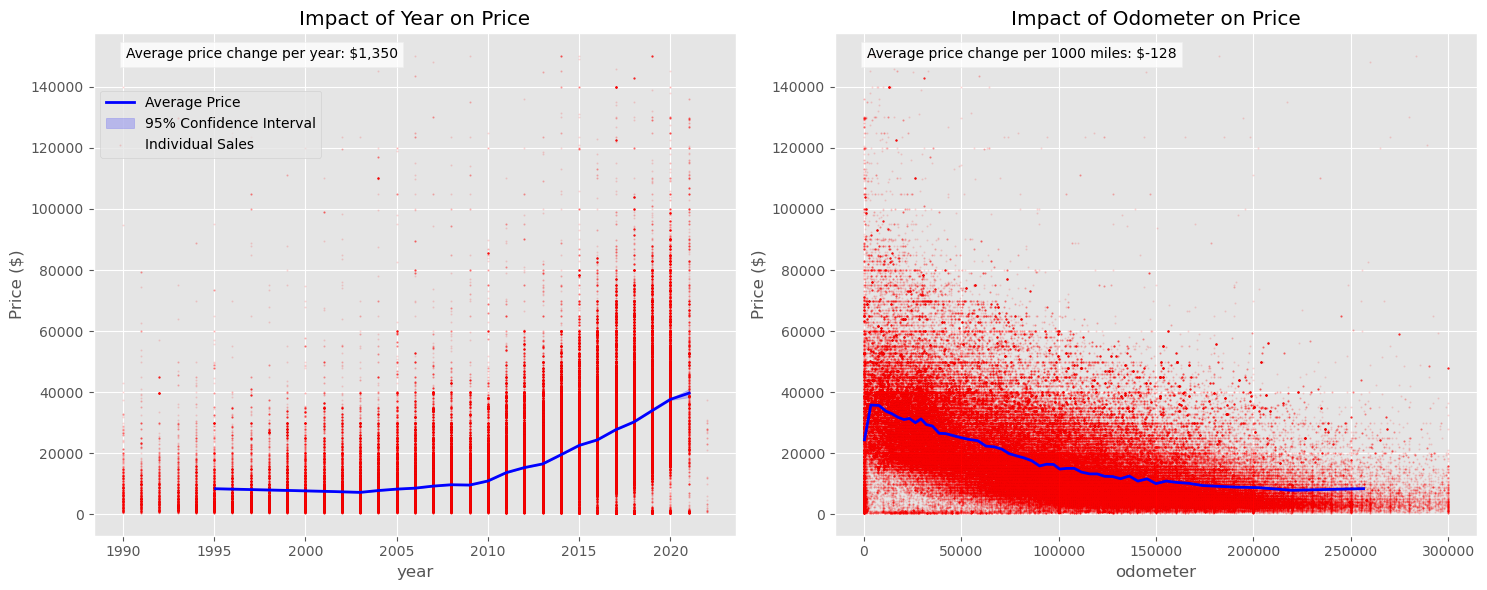

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_price_dependencies(df, features=['year', 'odometer']):
    """Analyze how changes in specific features affect price"""
    
    # Prepare the data
    df_clean = df.copy()
    
    # Basic cleaning
    df_clean = df_clean[
        (df_clean['price'] > 500) &
        (df_clean['year'] >= 1900)
    ]
    
    # Handle missing values
    df_clean = df_clean.dropna(subset=['price'] + features)
    
    # Create figure for plots
    plt.figure(figsize=(15, 6))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(1, 2, i)
        
        # Calculate average prices for each feature value
        df_grouped = df_clean.groupby(pd.qcut(df_clean[feature], 50, duplicates='drop'))
        feature_price_data = df_grouped['price'].agg(['mean', 'std', 'count']).reset_index()
        
        # Get the mean value of each bin for x-axis
        feature_price_data[feature] = df_grouped[feature].mean().values
        
        # Filter for significance and sort
        feature_price_data = feature_price_data[feature_price_data['count'] > 10]
        feature_price_data = feature_price_data.sort_values(feature)
        
        # Calculate confidence intervals
        z_score = 1.96  # for 95% confidence interval
        feature_price_data['ci'] = z_score * (feature_price_data['std'] / 
                                            np.sqrt(feature_price_data['count']))
        
        # Plot main trend line
        plt.plot(feature_price_data[feature], 
                feature_price_data['mean'], 
                'b-', 
                linewidth=2,
                label='Average Price')
        
        # Add confidence intervals
        plt.fill_between(feature_price_data[feature],
                        feature_price_data['mean'] - feature_price_data['ci'],
                        feature_price_data['mean'] + feature_price_data['ci'],
                        alpha=0.2,
                        color='blue',
                        label='95% Confidence Interval')
        
        # Add scatter plot of actual data points
        plt.scatter(df_clean[feature], 
                   df_clean['price'],
                   alpha=0.1,
                   color='red',
                   s=1,
                   label='Individual Sales')
        
        # Calculate and annotate trend
        if len(feature_price_data) > 1:  # Ensure we have enough points for regression
            slope = np.polyfit(feature_price_data[feature], 
                             feature_price_data['mean'], 1)[0]
            
            if feature == 'year':
                annotation_text = f'Average price change per year: ${slope:,.0f}'
            else:
                annotation_text = f'Average price change per 1000 miles: ${slope*1000:,.0f}'
            
            plt.text(0.05, 0.95, 
                    annotation_text,
                    transform=plt.gca().transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
        
        # Formatting
        plt.title(f'Impact of {feature.capitalize()} on Price')
        plt.xlabel(feature)
        plt.ylabel('Price ($)')
        if i == 1:  # Only show legend for first plot
            plt.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
        
        # Print statistical analysis
        print(f"\n{feature.capitalize()} Analysis:")
        print("="*50)
        print(f"Range: {df_clean[feature].min():,.0f} to {df_clean[feature].max():,.0f}")
        
        percentiles = np.percentile(df_clean[feature], [25, 50, 75])
        print(f"Quartiles:")
        print(f"  25th: {percentiles[0]:,.0f}")
        print(f"  50th: {percentiles[1]:,.0f}")
        print(f"  75th: {percentiles[2]:,.0f}")
        
        correlation = df_clean[[feature, 'price']].corr().iloc[0,1]
        print(f"Correlation with price: {correlation:.3f}")
        
        # Calculate average prices at quartile points
        quartile_prices = []
        for p in [25, 50, 75]:
            quartile_value = np.percentile(df_clean[feature], p)
            mask = (df_clean[feature] >= quartile_value - 0.01 * quartile_value) & \
                  (df_clean[feature] <= quartile_value + 0.01 * quartile_value)
            quartile_price = df_clean.loc[mask, 'price'].mean()
            quartile_prices.append(quartile_price)
        
        print("\nAverage Prices at Quartiles:")
        print(f"  Q1 (25th percentile): ${quartile_prices[0]:,.2f}")
        print(f"  Q2 (50th percentile): ${quartile_prices[1]:,.2f}")
        print(f"  Q3 (75th percentile): ${quartile_prices[2]:,.2f}")
        
        print("\nPrice Changes Between Quartiles:")
        print(f"  Q1 to Q2: ${quartile_prices[1] - quartile_prices[0]:,.2f}")
        print(f"  Q2 to Q3: ${quartile_prices[2] - quartile_prices[1]:,.2f}")
        
    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_price_dependencies(df)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

There is a lot of good data and insights relative to that data above.  However, saying that year and odometer are the two highest correlated features is not interesting or useful in and of itself.
Every dealer knows that a current year model is worth substantially more than one from 5 years ago.  The question is, 'by how much'.
So my initial analysis identifies the most relevant features.  I then take a look at the two most prominent features and understand how they impact the price.
What we don't know is what price a dealer can purchase a car for.  Their decisions are based on profit and we don't have 1 of the two numbers relevant to decide that.  Therefore, I can tell a dealer how to decide what to put on the lot based on estimated profit, but I can't give them general guidelines on what types of vehicles to sell, as they may sell a lot but be unprofittable.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

The decision of what cars to sell needs to be a combination of profit per car and how many can you sell.  Unfortunately, we don't have access to purchase prices for this analysis.  The data is available to analyze both when a dealer can consider the offered purchase price of a car for the lot.

Dealers will be expected to know there local market which will dictate things such as how many trucks versus cars you sell.  This analysis does not consider location or regionality.  it is not considered because we are looking at total impact and regionality is not a factor.  For an individual dealer, location will be of prominent importance and will not be addressed in this analysis.

From a volume perspective gas and automatic transmission are vital.  Though diesel and trucks are desireable, just not at the same rate.  Depends on where you live.  I'm sure that regional influences here are critical but not considered in this analysis.

The issue with looking at many of the data points regarding avergae prices is that they don't help a dealer know what to carry.  Yes, a Porche sells for more than a Ford.  But are you making more profit if you sell a $100,000 car you bought for $90,000 than selling 2 Fords for $35,000 that you bought for $20,000.  So you need to look at number of sales and profit per sale.

Towards this end I looked at the top two (by a wide margin) of features that influence price...year and odometer.  By graphing the expected impact when isolated from other features we can get a sense of what the true value of the car is.  Most other features, such as model, truck or car, provide a base expectation from which to make a decision.  You don't decide to sell a Porche or Ford based on car sell price as mentioned above.

Dealers should look at the base price of a vehicle if it were new and then use the graphs of year and odometer impact on price to see what the car should sell for.  They can then look at their purchase price option and decide whether to carry that car or not based on a calculation of profit per that car type (Model, Maker, Gas, Transmission, etc) and how many they can sell.

# Next Steps:
1) Know your local market.  Volumes will adjust massively based on location.  Additional analysis should be computed to determine turnover rate for various makes and models.   Don't try to sell a Porche in South Dakota and don't try to sell a Jeep in Beverly Hills.  I can generate additional recommendations regionally.  This is analysis for all sales.  Regionality is important but not analyzed here.
2) Once you know what types of vehicles you want to sell, you can look at the factors that influence your profit per sale.  The primary two are year and odometer.  For future analysis we can start to look at features such as cylinders or fuel type for the same model and year to determine price impact.
3) For those features (Year and Odometer are graphed above) calculate the percentage decrease in value and apply to the car you can buy.  This should give you a profit estimate.  Multiply this by your volumes expectation (additional analysis) and you will know your gross profit expectations.

